In [0]:
! pip install tensorflow==2.1.0

In [0]:
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.2.0-rc2'

# Policy Gradient

## Theory

## Code

In [0]:
class Actor():
  def __init__(self, hidden_size, lr):
    self.model = tf.keras.Sequential()
    for i in range(len(hidden_size)):
      self.model.add(tf.keras.layers.Dense(hidden_size[i], input_dim = 4, activation='relu'))
    self.model.add(tf.keras.layers.Dense(2))
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    # self.compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    self.model.build()

  def compute_loss(self, selected_action, logits):
    actions_one_hot = tf.one_hot([selected_action], 2)
    negative_loglikelihoods = tf.nn.softmax_cross_entropy_with_logits(labels=actions_one_hot, logits=logits)
    # Below step is instead completed by multiplying gradients with discounted_rewards
    # weighted_negative_loglikelihoods = tf.math.multiply(negative_loglikelihoods*discounted_rewards)
    loss = tf.reduce_sum(negative_loglikelihoods)
    return loss

  def init_grad_memory(self):
    grad_memory = self.model.trainable_variables
    for i, grad in enumerate(grad_memory):
      grad_memory[i] = grad * 0
    return grad_memory

  def discount_rewards(self, r, gamma):
      discounted_r = np.zeros_like(r)
      running_add = 0
      for t in reversed(range(0, r.size)):
          running_add = running_add * gamma + r[t]
          discounted_r[t] = running_add
      return discounted_r

In [0]:
def policy_gradient(seed, actor, n_episodes, gamma, batch_size):
  env = gym.make('CartPole-v0')
  action_size = 2

  env.seed(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)

  e_scores = []
  actor_grad_memory = actor.init_grad_memory()

  for episodes in range(n_episodes):
    
    s = env.reset()
    memory = []
    cum_score = 0
    done = False 
    while not done: 
      s = s.reshape([1,4])
      with tf.GradientTape() as tape:
        logits = actor.model(s)
        probs = tf.nn.softmax(logits)
        action = np.random.choice(action_size, p=probs.numpy()[0])
        loss = actor.compute_loss(action, logits)

      # Making a step in the action selected
      s, r, done, _ = env.step(action)
      cum_score += r

      grads = tape.gradient(loss, actor.model.trainable_variables)
      memory.append([grads,r])
      
    e_scores.append(cum_score)
    memory = np.array(memory)

    # Discounting the rewards and multiplying with gradients later 
    memory[:,1] = actor.discount_rewards(memory[:,1], gamma)
    
    # Weighting the gradients with discounted rewards
    for grads, G in memory:
      for i,grad in enumerate(grads):
        actor_grad_memory[i] +=  grad * G 
    
    # Updating weights once the batch is filled
    if episodes % batch_size == 0:
      actor.optimizer.apply_gradients(zip(actor_grad_memory,
                                          actor.model.trainable_variables))
      actor_grad_memory = actor.init_grad_memory()
        
    if episodes % 100 == 0:
      print("Episode  {}  Score  {}".format(episodes, np.mean(e_scores[-100:])))

  return e_scores

In [0]:
final_score_policy_gradient = []
for i in [1, 100, 345, 768, 123]:
  actor = Actor(hidden_size=[64], lr = 0.01)
  print("Seed", i)
  score = policy_gradient(i, actor, n_episodes=2000, gamma=0.99, batch_size=5)
  final_score_policy_gradient.append(score)

Seed 1
Episode  0  Score  13.0
Episode  100  Score  66.02
Episode  200  Score  170.42
Episode  300  Score  180.55
Episode  400  Score  151.36
Episode  500  Score  188.94
Episode  600  Score  132.52
Episode  700  Score  96.49
Episode  800  Score  189.9
Episode  900  Score  198.74
Episode  1000  Score  199.73
Episode  1100  Score  198.35
Episode  1200  Score  200.0
Episode  1300  Score  199.67
Episode  1400  Score  189.55
Episode  1500  Score  200.0
Episode  1600  Score  176.53
Episode  1700  Score  200.0
Episode  1800  Score  200.0
Episode  1900  Score  200.0
Seed 100
Episode  0  Score  32.0
Episode  100  Score  73.56
Episode  200  Score  171.47
Episode  300  Score  178.34
Episode  400  Score  172.05
Episode  500  Score  195.07
Episode  600  Score  179.96
Episode  700  Score  176.7
Episode  800  Score  190.38
Episode  900  Score  176.74
Episode  1000  Score  157.25
Episode  1100  Score  68.67
Episode  1200  Score  67.04
Episode  1300  Score  92.98
Episode  1500  Score  105.33
Episode  1

## Experiments

### Graph

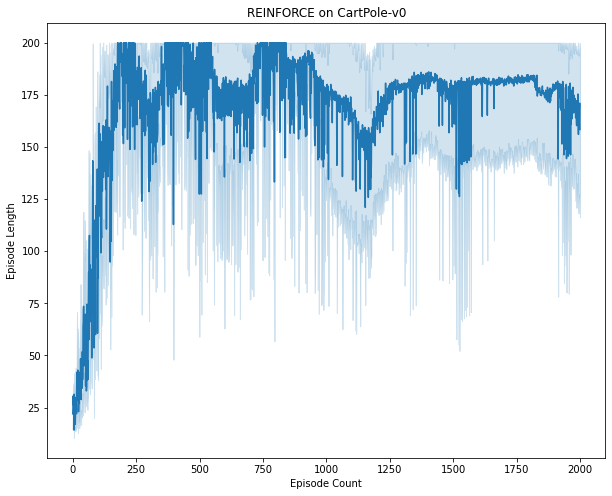

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df = pd.melt(pd.DataFrame(final_score_policy_gradient),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df)
plt.xlabel("Episode Count")
plt.ylabel("Episode Length")
plt.title("REINFORCE on CartPole-v0");

### Hyper Parameter Discussion

### Observation

dadadad

# Actor-Critic 

## Theory

## Code

In [0]:
class Base():
  def init_grad_memory(self):
    grad_memory = self.model.trainable_variables
    for i, grad in enumerate(grad_memory):
      grad_memory[i] = grad * 0
    return grad_memory

class Actor(Base):
  def __init__(self, hidden_size, lr):
    self.model = tf.keras.Sequential()
    for i in range(len(hidden_size)):
      self.model.add(tf.keras.layers.Dense(hidden_size[i], input_dim = 4, activation='relu'))
    self.model.add(tf.keras.layers.Dense(2))
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    # self.compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    self.model.build()

  def compute_loss(self, selected_action, logits, td_error):
    actions_one_hot = tf.one_hot([selected_action], 2)
    negative_loglikelihoods = tf.nn.softmax_cross_entropy_with_logits(labels=actions_one_hot, logits=logits)
    weighted_negative_loglikelihoods = tf.math.multiply(negative_loglikelihoods, td_error)
    loss = tf.reduce_sum(weighted_negative_loglikelihoods)
    return loss

class Critic(Base):
  def __init__(self, hidden_size, lr):
    self.model = tf.keras.Sequential()
    for i in range(len(hidden_size)):
      self.model.add(tf.keras.layers.Dense(hidden_size[i], input_dim = 4, activation='relu'))
    self.model.add(tf.keras.layers.Dense(1))
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    self.compute_loss = tf.keras.losses.MeanSquaredError()
    self.model.build()

In [0]:
def actor_critic(seed, actor, critic, n_episodes, gamma, batch_size):
  
  env = gym.make('CartPole-v0')
  
  # Set seeds
  tf.random.set_seed(seed)
  np.random.seed(seed)
  env.seed(seed)

  actor_grad_memory = actor.init_grad_memory()
  critic_grad_memory = critic.init_grad_memory()
  e_scores = []

  for episodes in range(n_episodes):
    s_curr = env.reset()
    
    memory = []
    cum_score = 0
    done = False 
    while not done: 
      s_curr = s_curr.reshape([1,4])
      with tf.GradientTape(persistent=True) as tape:
        #Action from Actor
        logits = actor.model(s_curr)
        probs = tf.nn.softmax(logits)
        selected_action = np.random.choice(2, p=probs.numpy()[0])

        # logits = actor.model(s_curr)
        # a_dist = logits.numpy()
        # # Choose random action with p = action dist
        # a = np.random.choice(a_dist[0],p=a_dist[0])
        # selected_action = np.argmax(a_dist == a)
        # actor_loss = actor.compute_loss(y_true=[selected_action],
        #                                 y_pred=logits)
        #Value function from Critic
        v_s_curr = critic.model(s_curr)

        #Take step with Actor's selected action. 
        s_new, r, done, _ = env.step(selected_action)

        #Adjust true value function with prediction by Critic 
        s_new = s_new.reshape([1,4])

        #The target is the sum of the reward recieved 
        #plus the discounted, predicted reward of the new state
        v_s_new = critic.model(s_new)
        td_target = r + gamma*v_s_new
        td_error = td_target - v_s_curr
        critic_loss = critic.compute_loss(y_true=td_target,
                                          y_pred=v_s_curr)
        actor_loss = actor.compute_loss(selected_action, logits, td_error)
        # actor_loss = -tf.math.log(selected_action) * tf.squeeze(td_target)


      s_curr = s_new
      cum_score += r

      actor_grads = tape.gradient(actor_loss, actor.model.trainable_variables)
      critic_grads = tape.gradient(critic_loss, critic.model.trainable_variables)
      memory.append([actor_grads, critic_grads, td_error, td_target, v_s_curr])

    e_scores.append(cum_score)
    # print(actor_loss, critic_loss)
    # The TD Error calculated above is already discounted 
    
    for actor_grads, critic_grads, td_error, td_target, v_s_curr in memory:
      for i, grad in enumerate(actor_grads):
        actor_grad_memory[i] += grad  #* tf.squeeze(td_error)
      for i, grad in enumerate(critic_grads):
        critic_grad_memory[i] += grad #* tf.squeeze(td_error)
        
      
    if episodes % batch_size == 0:
      actor.optimizer.apply_gradients(zip(actor_grad_memory,
                                          actor.model.trainable_variables))
      critic.optimizer.apply_gradients(zip(critic_grad_memory,
                                          critic.model.trainable_variables))

      actor_grad_memory = actor.init_grad_memory()
      critic_grad_memory = critic.init_grad_memory()
        
    if episodes % 100 == 0:
      print("Episode  {}  Score  {}".format(episodes, np.mean(e_scores[-100:])))
  
  return e_scores

## Experiments

In [0]:
final_score = []
for i in [1, 100, 345, 768, 123]:
  actor = Actor(hidden_size=[64], lr=0.01)
  critic = Critic(hidden_size=[64], lr=0.01)
  print("Seed", i)
  score = actor_critic(i, actor, critic, n_episodes=2000, gamma=0.99, batch_size=10)
  final_score.append(score)

Seed 1
Episode  0  Score  13.0
Episode  100  Score  28.41
Episode  200  Score  57.82
Episode  300  Score  75.8
Episode  400  Score  93.55
Episode  500  Score  92.72
Episode  600  Score  97.78
Episode  700  Score  70.96
Episode  800  Score  64.51
Episode  900  Score  61.96
Episode  1000  Score  85.9
Episode  1100  Score  74.17
Episode  1200  Score  51.34
Episode  1300  Score  48.33
Episode  1400  Score  55.57
Episode  1500  Score  89.07
Episode  1600  Score  94.8
Episode  1700  Score  70.83
Episode  1800  Score  138.69
Episode  1900  Score  199.57
Seed 100
Episode  0  Score  32.0
Episode  100  Score  36.64
Episode  200  Score  52.43
Episode  300  Score  53.53
Episode  400  Score  75.69
Episode  500  Score  69.26
Episode  600  Score  79.68
Episode  700  Score  116.53
Episode  800  Score  141.73
Episode  900  Score  114.8
Episode  1000  Score  130.6
Episode  1100  Score  21.56
Episode  1200  Score  26.61
Episode  1300  Score  54.41
Episode  1400  Score  165.69
Episode  1500  Score  198.71

In [0]:
final_score = []
for i in [1, 100, 345, 768, 123]:
  actor = Actor(hidden_size=[64], lr=0.01)
  critic = Critic(hidden_size=[64], lr=0.01)
  print("Seed", i)
  score = actor_critic(i, actor, critic, n_episodes=2000, gamma=0.99, batch_size=5)
  final_score.append(score)

Seed 1
Episode  0  Score  13.0
Episode  100  Score  27.44
Episode  200  Score  47.36
Episode  300  Score  59.96
Episode  400  Score  58.14
Episode  500  Score  82.22
Episode  600  Score  60.28
Episode  700  Score  88.72
Episode  800  Score  78.39
Episode  900  Score  89.76
Episode  1000  Score  92.03
Episode  1100  Score  95.33
Episode  1200  Score  82.08
Episode  1300  Score  74.87
Episode  1400  Score  68.19
Episode  1500  Score  72.35
Episode  1600  Score  73.09
Episode  1700  Score  70.93
Episode  1800  Score  65.18
Episode  1900  Score  67.03
Seed 100
Episode  0  Score  32.0
Episode  100  Score  36.3
Episode  200  Score  46.72
Episode  300  Score  63.8
Episode  400  Score  64.23
Episode  500  Score  81.19
Episode  600  Score  70.21
Episode  700  Score  60.4
Episode  800  Score  96.77
Episode  900  Score  90.03
Episode  1000  Score  88.82
Episode  1100  Score  72.09
Episode  1200  Score  77.2
Episode  1300  Score  86.44
Episode  1400  Score  91.1
Episode  1500  Score  84.99
Episode

### Graph

Text(0.5, 1.0, 'Vanilla Actor-Critic on CartPole-v0')

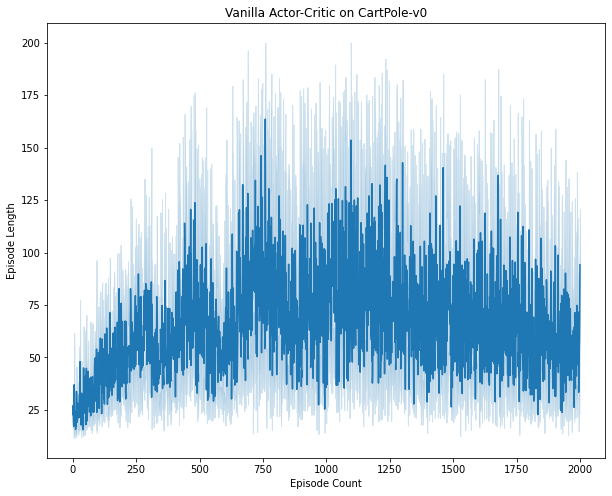

In [0]:
final_score_actor_critic = final_score
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df = pd.melt(pd.DataFrame(final_score_actor_critic),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df)
plt.xlabel("Episode Count")
plt.ylabel("Episode Length")
plt.title("Vanilla Actor-Critic on CartPole-v0");

### Hyper Parameter Discussion

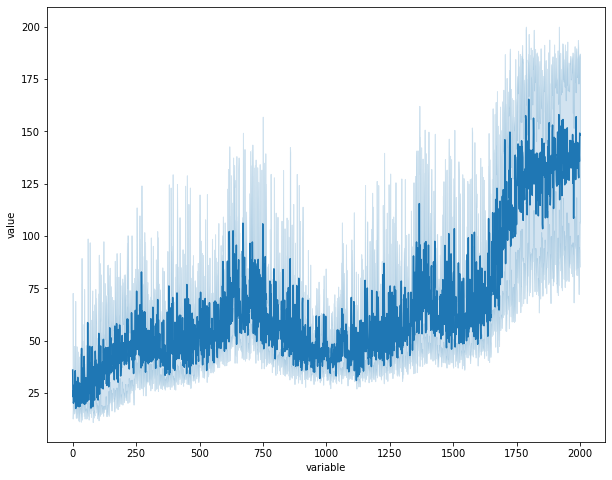

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df = pd.melt(pd.DataFrame(final_score),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df)

### Observation

# Comparing REINFORCE vs One-step Actor Critic 

## Graph

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df_reinforce = pd.melt(pd.DataFrame(final_score_policy_gradient),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df)

df_actor_critic = pd.melt(pd.DataFrame(final_score_actor_critic),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df)
plt.legends(['REINFORCE', '1-step Actor-Critic'])
plt.xlabel("Episode Count")
plt.ylabel("Episode Length")
plt.title("Reinforce VS Actor-Critic on CartPole-v0")

## Final Observations